# Building databases of published works  

> Pragmatic tools for constructing databases of scientific works based on queries defined with Boolean Logic.

In [1]:
#| default_exp utils.db

In [2]:
#| hide
from nbdev import *

Tabulate queries in a spreadsheet and generate a database based on the data from those queries. 

**Example**:  Define a dataframe with an `id` column and a `query` column (expressing a search query in Boolean Logic):

| ID | DISEASE NAME | QUERY  | 
|----|--------------|--------|
| 1 | Adult Polyglucosan Body Disease | adult polyglucosan body disease \| adult polyglucosan body neuropathy
| 2 | AGAT deficiency |  "GATM deficiency" \| "AGAT deficiency" \| "arginine:glycine amidinotransferase deficiency" \| "L-arginine:glycine amidinotransferase deficiency"
| 3 | Guanidinoacetate methyltransferase deficiency | "guanidinoacetate methyltransferase deficiency" \| "GAMT deficiency"
| 4 | CLOVES Syndrome | "CLOVES syndrome \| (congenital lipomatous overgrowth) & (vascular malformation epidermal) & (nevi-spinal) & syndrome \| (congenital lipomatous overgrowth) & (vascular malformations) & (Epidermal nevi) & ((skeletal\|spinal) & abnormalities) \| CLOVE syndrome \| (congenital lipomatous overgrowth) & (vascular malformation) & (epidermal nevi)


In [2]:
#| export

import local_resources.linkml as linkml

from alhazen.utils.airtableUtils import AirtableUtils
from alhazen.utils.searchEngineUtils import ESearchQuery, EuroPMCQuery
from alhazen.utils.queryTranslator import QueryTranslator, QueryType
import alhazen.schema_sqla as linkml_sqla
import alhazen.schema_python as linkml_py
from alhazen.utils.jats_text_extractor import NxmlDoc
from alhazen.utils.local_literature_db import *

from bs4 import BeautifulSoup,Tag,Comment,NavigableString
from databricks import sql
from datetime import datetime
from importlib_resources import files
import os
import pandas as pd
from pathlib import Path
import re
import requests
from sqlalchemy import create_engine, exists
from sqlalchemy.orm import sessionmaker
from time import time,sleep
from tqdm import tqdm
from urllib.request import urlopen
from urllib.parse import quote_plus, quote, unquote
from urllib.error import URLError, HTTPError

In [4]:
db = LocalLiteratureDb('/Users/gburns/alhazen/', 'em_tech' )
if db.session is None:
    session_class = sessionmaker(bind=db.engine)
    db.session = session_class()

In [8]:
from io import StringIO

EM_QUERIES_TSV = '''
ID,NAME,QUERY
0,Hierarchical phase-contrast tomography,Hierarchical phase-contrast tomography | HIP-CT | Hierarchical phase contrast tomography
1,Cryo-Electron Tomography,Cryoelectron Tomography | Cryo Electron Tomography | Cryo-Electron Tomography | Cryo-ET | CryoET
2,Volume Electron Microscopy,Volume Electron Microscopy | Volume EM | (serial section & (electron microscopy | EM | transmission electron microscopy | TEM | scanning electron microscopy | SEM | electron tomography )) | (serial block-face & (SEM | scanning electron microscopy)) | (focused ion beam & (SEM | scanning electron microscopy)) | (automated serial & (TEM | transmission electron microscopy)) | ( massively parallel imaging & (SEM | scanning electron microscopy)) | multibeam SEM | FAST-SEM | cryo-TEM
'''
EM_QUERIES_TSV = '''
ID,NAME,QUERY
0,Cryo-Electron Tomography,Cryoelectron Tomography | Cryo Electron Tomography | Cryo-Electron Tomography | Cryo-ET | CryoET
'''

cdf = pd.read_csv(StringIO(EM_QUERIES_TSV), sep=',')
qs = QuerySpec('EM Technology', 'ID', 'QUERY', 'NAME', {}, ['TITLE','ABSTRACT', 'METHODS'])
qt = QueryTranslator(cdf.sort_values('ID'), 'ID', 'QUERY', 'NAME')

db.add_corpus_from_epmc(qt, None, sections=qs.sections)


100%|██████████| 1/1 [00:00<00:00, 1434.44it/s]


https://www.ebi.ac.uk/europepmc/webservices/rest/search?format=JSON&pageSize=1000&synonym=TRUE&resultType=core&query=((TITLE:"Cryoelectron Tomography" OR ABSTRACT:"Cryoelectron Tomography" OR METHODS:"Cryoelectron Tomography") OR (TITLE:"Cryo Electron Tomography" OR ABSTRACT:"Cryo Electron Tomography" OR METHODS:"Cryo Electron Tomography") OR (TITLE:"Cryo-Electron Tomography" OR ABSTRACT:"Cryo-Electron Tomography" OR METHODS:"Cryo-Electron Tomography") OR (TITLE:"Cryo-ET" OR ABSTRACT:"Cryo-ET" OR METHODS:"Cryo-ET") OR (TITLE:"CryoET" OR ABSTRACT:"CryoET" OR METHODS:"CryoET")), 2442 European PMC PAPERS FOUND


100%|██████████| 3/3 [00:24<00:00,  8.09s/it]


 Returning 2442


100%|██████████| 2442/2442 [00:05<00:00, 425.28it/s]


In [5]:
list_c = db.session.query(linkml_sqla.ScientificPublicationCollection).all()
for c in list_c:
  print('ID: %s | Name: %s'%(c.id,c.name))  

ID: 0 | Name: Cryo-Electron Tomography


In [6]:
import urllib

os.environ['NCBI_API_KEY'] = '<add your key here>'

path = '/users/gburns/alhazen/em_tech/nxml_files/'
dois = set()
for p in db.session.query(linkml_sqla.ScientificPublication).all():
    if p.doi in dois:
        continue
    dois.add(p.doi)
    if os.path.exists(path+p.doi+'.nxml'):
        print('Skipping %s, already exists'%(p.doi))
        continue
    print('ID: %s | Title: %s | DOI: %s'%(p.id, p.title, p.doi))  
    try:   
        get_nxml_from_pubmed_doi(p.doi, path)
    except URLError as ue:
        dois.remove(p.doi)
    except HTTPError as he:
        dois.remove(p.doi)


Skipping 10.1038/s41467-023-42085-w, already exists
Skipping 10.1038/s41467-023-41156-2, already exists
Skipping 10.3389/fpls.2023.1261180, already exists
Skipping 10.1042/bst20230103, already exists
ID: PPR693122 | Title: <i>In situ</i>cryo-electron tomography of β-amyloid and tau in post-mortem Alzheimer’s disease brain | DOI: 10.1101/2023.07.17.549278
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?api_key=d086451c882fabace54d7b049b6fb8481908&db=pmc&term=10.1101/2023.07.17.549278[doi]&retmode=xml
No paper found with that DOI
ID: PPR720228 | Title: High-confidence 3D template matching for cryo-electron tomography | DOI: 10.1101/2023.09.05.556310
https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?api_key=d086451c882fabace54d7b049b6fb8481908&db=pmc&term=10.1101/2023.09.05.556310[doi]&retmode=xml
No paper found with that DOI
Skipping 10.1038/s41598-023-32716-z, already exists
ID: 37348443 | Title: Cryo-electron tomography of viral infection - from applications to bios

In [ ]:
path = '/users/gburns/alhazen/em_tech/pdf_files/'
if os.path.exists(path) is False:
    os.makedirs(path)
dois = set()
#for i, p in enumerate(db.list_corpus_publications('0')):
for p in db.session.query(linkml_sqla.ScientificPublication).all():
    if p.doi in dois:
        continue
    dois.add(p.doi)
    if os.path.exists(path+p.doi+'.nxml'):
        print('Skipping %s, already exists'%(p.doi))
        continue
    print('ID: %s | Title: %s | DOI: %s'%(p.id, p.title, p.doi))  
    try:   
        get_pdf_from_pubmed_doi(p.doi, path)
    except URLError as ue:
        dois.remove(p.doi)
    except HTTPError as he:
        dois.remove(p.doi)


In [8]:

pdf_path = '/tmp/alhazen/pdf_files/'
nxml_path = '/tmp/alhazen/nxml_files/'

l = []
for p in tqdm(db.list_corpus_publications('1')):

    has_full_text = False
    has_full_text_methods = False
    has_pdf = False
    
    pdf_file_path = pdf_path+p.doi+'.pdf'
    if os.path.exists(pdf_file_path):
        has_pdf = True

    nxml_file_path = nxml_path+p.doi+'.nxml'
    if os.path.exists(nxml_file_path):
        with open(nxml_file_path, 'r') as f:
            xml = f.read()
            soup = BeautifulSoup(xml, "lxml")
        body = soup.find_all('body')
        if body:
            has_full_text = True
        d = NxmlDoc(p.doi, xml)
        m = '\n'.join([d.read_section_text(sec) for sec in d.search_section_titles('methods')])
        if(len(m) > 0):
            has_full_text_methods = True

    l.append({'id':p.id, 'title':p.title, 'doi':p.doi, 'pub_date':p.publication_date, 'has_full_text':has_full_text, 'has_full_text_methods':has_full_text_methods, 'has_pdf':has_pdf})

df = pd.DataFrame(l)
df        

0it [00:00, ?it/s]


AttributeError: 'NoneType' object has no attribute 'has_part'

In [33]:
print( df[df.has_pdf==True].shape ) 
print( df[df.has_full_text==True].shape ) 
print( df[df.has_full_text_methods==True].shape ) 
print( df.shape ) 


(205, 7)
(1506, 7)
(490, 7)
(2413, 7)


In [1]:
years = [row.pub_date.year for i, row in df.iterrows() if row.pub_date.year>2000]

# draw histogram of publication years
import matplotlib.pyplot as plt
import numpy as np
plt.hist(years, bins=np.arange(min(years), max(years) + 1, 1))


NameError: name 'df' is not defined

(array([  1.,   0.,   2.,   4.,   7.,  18.,  25.,  27.,  36.,  51.,  52.,
         56.,  60.,  75.,  69.,  79.,  99., 121., 162., 181., 381.]),
 array([2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010.,
        2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019.,
        2020., 2021., 2022., 2023.]),
 <BarContainer object of 21 artists>)

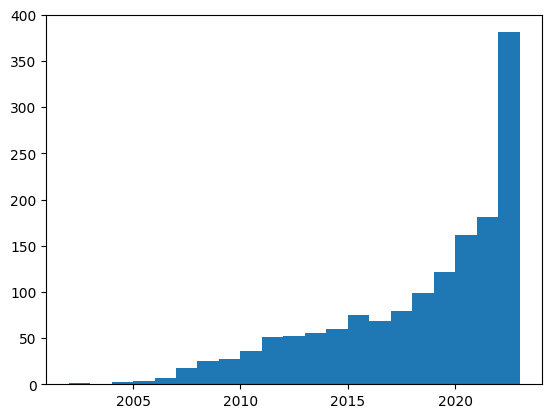

In [46]:
year1 = [row.pub_date.year for i, row in df.iterrows() if row.pub_date.year>2000 and (row.has_full_text | row.has_pdf)]
year2 = [row.pub_date.year for i, row in df.iterrows() if row.pub_date.year>2000]


# draw histogram of publication years
import matplotlib.pyplot as plt
import numpy as np
plt.hist(years, bins=np.arange(min(years), max(years) + 1, 1))


years = [row.pub_date.year for i, row in df.iterrows() if row.pub_date.year>2000 and row.has_full_text==True]

# draw histogram of publication years
import matplotlib.pyplot as plt
import numpy as np
plt.hist(years, bins=np.arange(min(years), max(years) + 1, 1))


In [8]:

db = LocalLiteratureDb('em_literature', 'EuropePMC papers based on EM keywords', '/tmp/alhazen/')
if db.session is None:
    session_class = sessionmaker(bind=db.engine)
    db.session = session_class()

print([c.name for c in db.list_corpora()])

path = '/tmp/alhazen/nxml_files/'
methods = []
for i, p in enumerate(db.list_corpus_publications('1')):
    nxml_path = path+p.doi+'.nxml'
    if os.path.exists(nxml_path):
        with open(nxml_path, 'r') as f:
            xml = f.read()
            d = NxmlDoc(p.doi, xml)
            #print(p.doi)
            #print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            #for sec in d.search_section_titles('methods'):
            #    print(d.read_section_text(sec)) 
            #print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            m = '\n'.join([d.read_section_text(sec) for sec in d.search_section_titles('methods')])
            if(len(m) > 0):
                methods.append(m)

lengths = [(len(m) - len(re.sub('\s+','',m))) for m in methods]
lengths

['Hierarchical phase-contrast tomography', 'Cryo-Electron Tomography', 'Volume Electron Microscopy']


/Users/gburns/Documents/Coding/ChatGPT_etc/alzhazen/alhazen/utils/jats_text_extractor.py:179: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if (title_tag and query in title_tag.text.lower()) or \
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi

Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty 

Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)


Type Error: this element does not have children or attributes
Type Error: this element does not have children or attributes
Type Error: this element does not have children or attributes
Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)


Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)


Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty 

Type Error: this element does not have children or attributes
Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)


Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)


Type Error: this element does not have children or attributes
Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty 

Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty 

Type Error: this element does not have children or attributes
Type Error: this element does not have children or attributes
Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty 

Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)


Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)


Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty 

Type Error: this element does not have children or attributes
Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)


Type Error: this element does not have children or attributes
Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty 

Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)


Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty 

Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty 

Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)


Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)


Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty 

Type Error: this element does not have children or attributes
Type Error: this element does not have children or attributes
Type Error: this element does not have children or attributes
Type Error: this element does not have children or attributes
Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty 

Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty 

Type Error: this element does not have children or attributes
Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)


Type Error: this element does not have children or attributes
Type Error: this element does not have children or attributes


rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty output)
rewritetex: likely error invoking catdvi (empty 

Type Error: this element does not have children or attributes


[1185,
 719,
 457,
 676,
 1735,
 639,
 2384,
 944,
 3174,
 2040,
 21,
 2191,
 2282,
 945,
 638,
 982,
 1529,
 1123,
 3953,
 965,
 2223,
 3864,
 1261,
 4292,
 1458,
 814,
 931,
 335,
 2087,
 659,
 1256,
 929,
 1682,
 1010,
 6224,
 1622,
 1061,
 1368,
 892,
 3304,
 2125,
 695,
 647,
 677,
 1052,
 1913,
 2052,
 915,
 1000,
 1167,
 1529,
 2249,
 867,
 6216,
 2654,
 1602,
 1965,
 1376,
 1847,
 1694,
 1729,
 4180,
 566,
 1380,
 893,
 994,
 2423,
 3630,
 1675,
 2136,
 2071,
 1041,
 1307,
 1069,
 1369,
 1976,
 2534,
 1470,
 1062,
 2469,
 2207,
 1176,
 2055,
 2570,
 1589,
 2128,
 2510,
 2524,
 831,
 1946,
 2302,
 1298,
 1999,
 1169,
 1031,
 533,
 2600,
 1711,
 1565,
 1822,
 1867,
 2112,
 1014,
 3620,
 1052,
 1589,
 2707,
 625,
 1135,
 2443,
 2930,
 1126,
 1954,
 2886,
 1766,
 284,
 3191,
 469,
 1504,
 2767,
 1015,
 1293,
 1921,
 1922,
 853,
 2243,
 2282,
 5302,
 3495,
 743,
 2067,
 1378,
 2259,
 1277,
 2448,
 1785,
 1641,
 1580,
 1233,
 3509,
 1210,
 1123,
 2276,
 1350,
 1997,
 1226,
 1370,
 97

In [15]:
len(lengths)


NameError: name 'lengths' is not defined

In [33]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
    Image(
      url="https://mermaid.ink/img/"
      + base64_string
    )
  )



In [7]:
engine = create_engine("sqlite:////tmp/alhazen/sciknow.db")
session_class = sessionmaker(bind=engine)
session = session_class()
p = linkml_sqla.ScientificPrimaryResearchPreprint(id=100, title='Test', abstract='Test abstract', iri='10.1234/1234', doi='10.1234/1234', publication_date=datetime.now())
session.add(p)
session.commit()

In [34]:
!rm /tmp/alhazen/tmp.db

In [29]:
!sqlite3 /tmp/alhazen/tmp.db "SELECT * FROM Work;" ".exit"

100|Test|Test abstract|||||||10.1234/1234


In [32]:
for w in session.query(Work).where(Work.id!=100):
    print(p.title)
